# Information content example: compute required bits

In [1]:
%load_ext autoreload
%autoreload
import fcpy

/workspace/field-compression/miniconda3/envs/fcpy/lib/python3.10/site-packages/ecmwflibs/__init__.py:69: UserWarning: ecmwflibs: ignoring provided 'GRIB_DEFINITION_PATH' set to '/workspace/field-compression/miniconda3/envs/fcpy/lib/metview-bundle/share/metview/etc/grib_def/definitions:/workspace/field-compression/miniconda3/envs/fcpy/./share/eccodes/definitions:/tmp/mv.2451./bufr_def'. If you want ecmwflibs to use this environment variable, use ECMWFLIBS_GRIB_DEFINITION_PATH instead. If you want to use your own ECCODES library, use ECMWFLIBS_ECCODES.
  warnings.warn(


In [2]:
"""

mars_rq = {
    "class": "od", # operational archive
    "date": "2000-01-01",
    "expver": "1", # ERA5
    "levelist": [str(i) for i in range(1,60+1)], # list of level names
    "levtype": "ml", # model levels
    "param": "133.128", # specific humidity
    "step": 240, # timestep
    "stream": "oper", # atmospheric model
    "time": "12:00:00",
    "type": "fc" # forecast
}

fcpy.fetch_mars_dataset(mars_rq)

"""

'\n\nmars_rq = {\n    "class": "od", # operational archive\n    "date": "2000-01-01",\n    "expver": "1", # ERA5\n    "levelist": [str(i) for i in range(1,60+1)], # list of level names\n    "levtype": "ml", # model levels\n    "param": "133.128", # specific humidity\n    "step": 240, # timestep\n    "stream": "oper", # atmospheric model\n    "time": "12:00:00",\n    "type": "fc" # forecast\n}\n\nfcpy.fetch_mars_dataset(mars_rq)\n\n'

In [3]:
ds = fcpy.open_dataset("../data/cams_q_20191201_v3.nc")

ds = ds[["q"]]
ds

<xarray.Dataset>
Dimensions:  (time: 1, lev: 137, lat: 451, lon: 900)
Coordinates:
  * time     (time) datetime64[ns] 2019-12-01T12:00:00
  * lon      (lon) float64 0.0 0.4 0.8 1.2 1.6 ... 358.0 358.4 358.8 359.2 359.6
  * lat      (lat) float64 -90.0 -89.6 -89.2 -88.8 -88.4 ... 88.8 89.2 89.6 90.0
  * lev      (lev) float64 1.0 2.0 3.0 4.0 5.0 ... 133.0 134.0 135.0 136.0 137.0
Data variables:
    q        (time, lev, lat, lon) float32 dask.array<chunksize=(1, 137, 451, 900), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Feb 15 18:37:28 2021: cdo -f nc4 copy tmp.grib data/mil...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

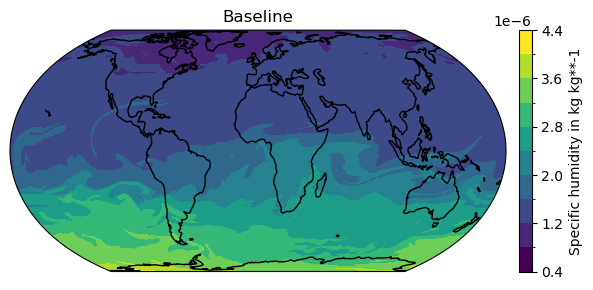

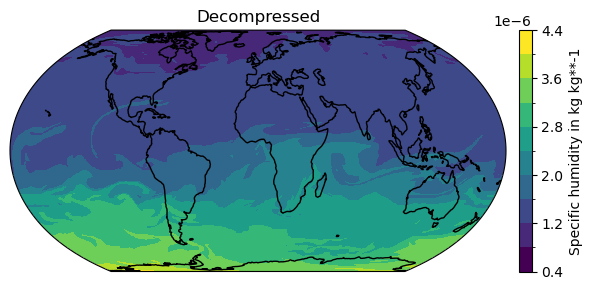

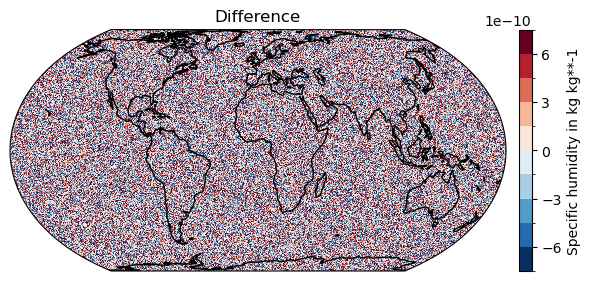

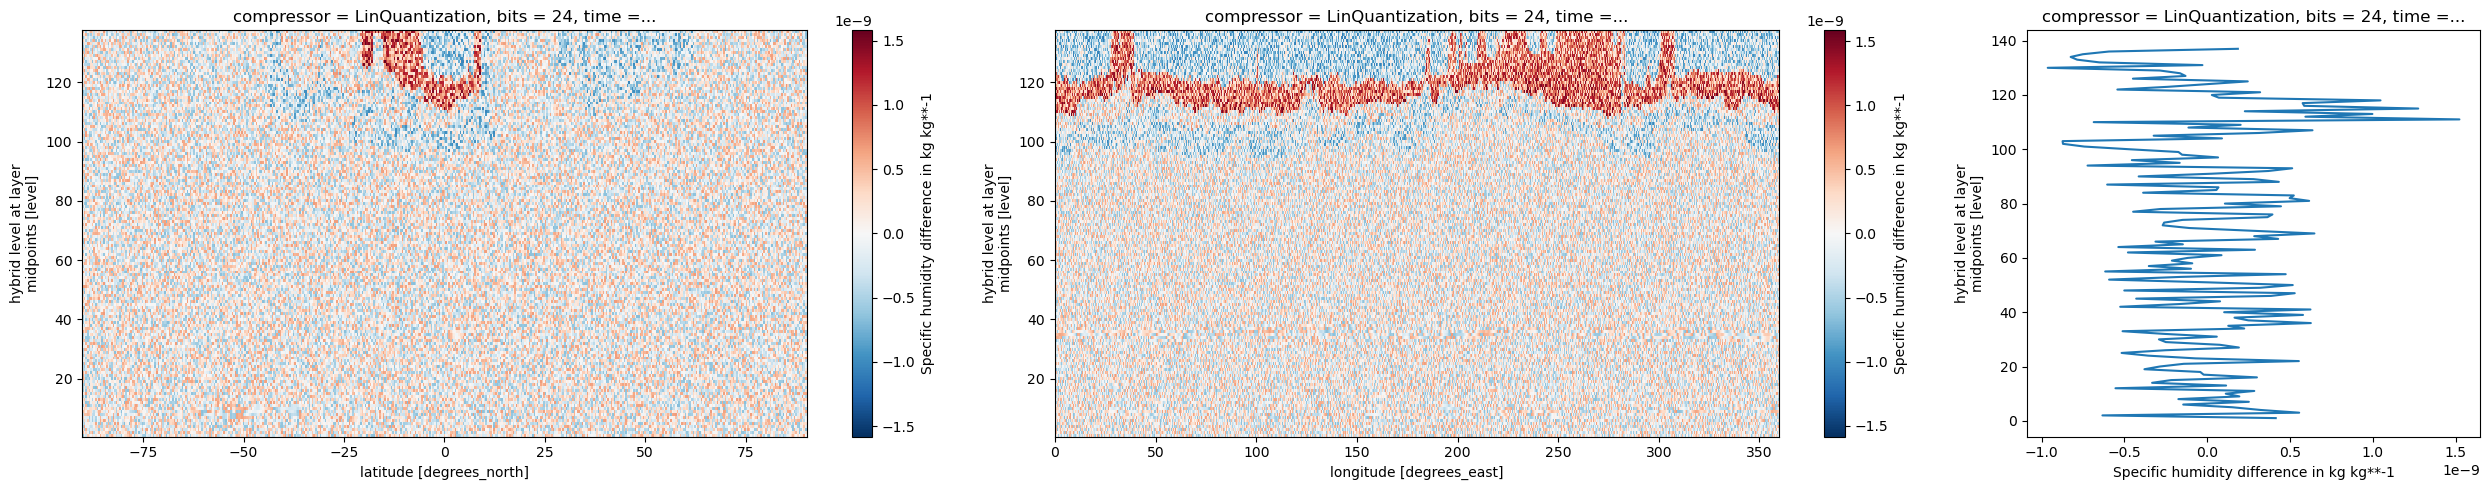

In [4]:
fcpy.spatialplot(
    ds=ds,
    baseline=fcpy.Float(bits=32),
    var_name="q",
    compressor=fcpy.LinQuantization(bits=24),
    metric=fcpy.Difference,
    latitude=0,
    longitude=0,
    lev=1,
    third_dim="lev",
)

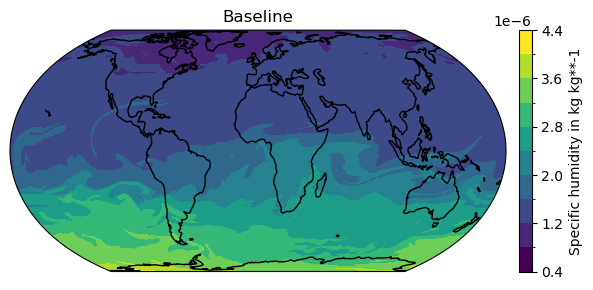

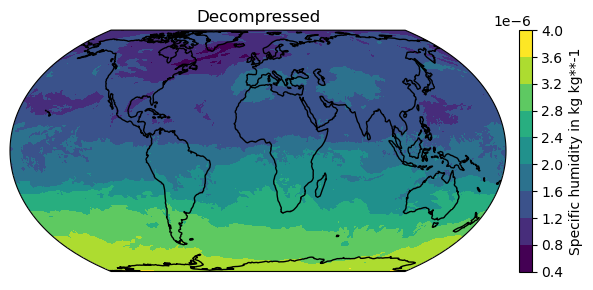

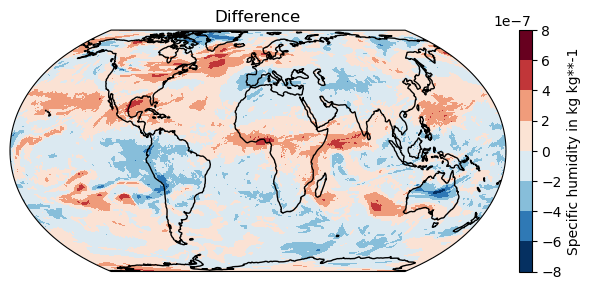

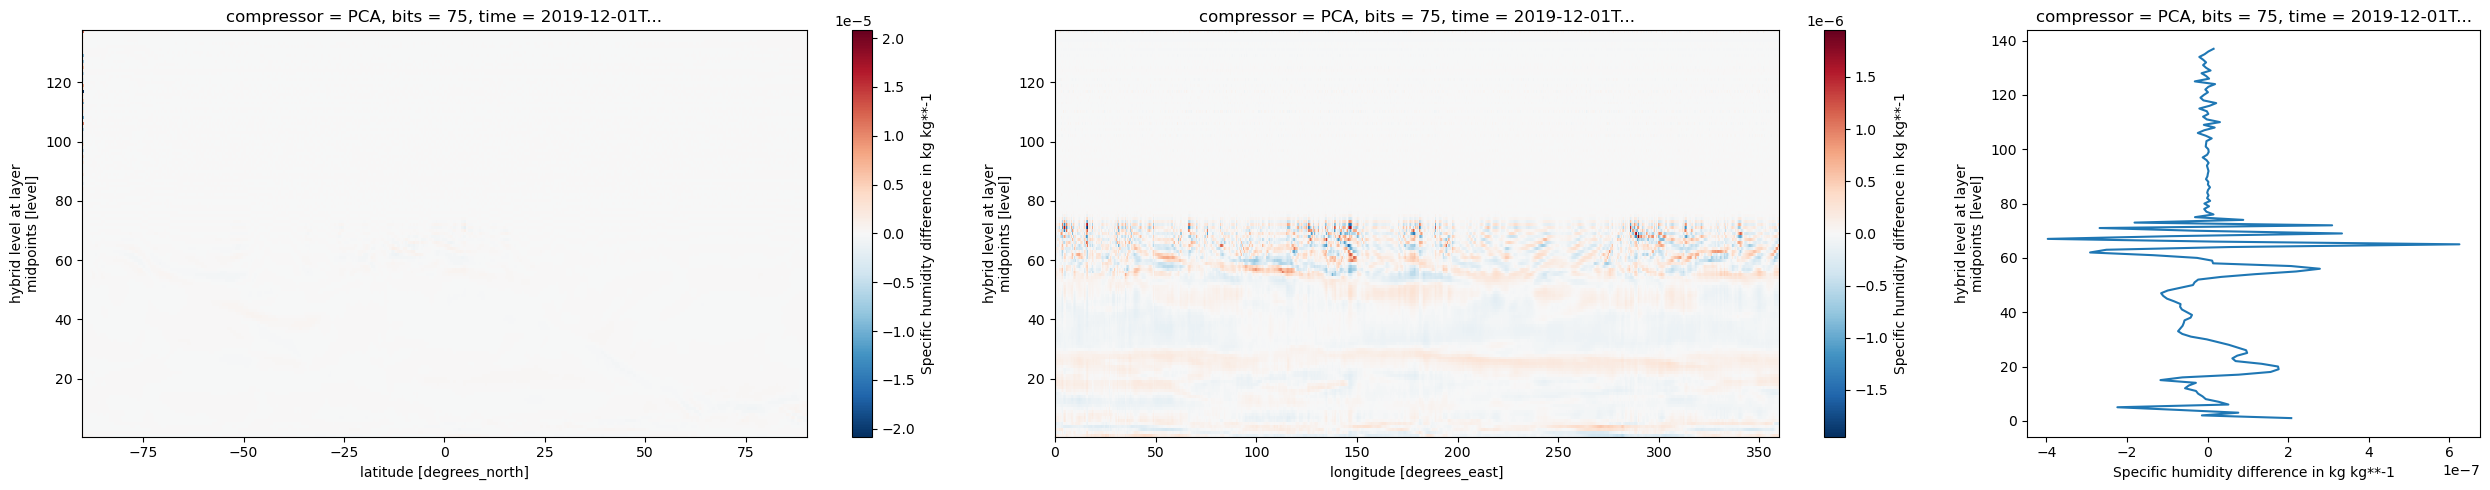

In [5]:
fcpy.spatialplot(
    ds=ds,
    baseline=fcpy.Identity(bits=32),
    var_name="q",
    compressor=fcpy.PCA(bits=75),
    metric=fcpy.Difference,
    latitude=0,
    longitude=0,
    lev=1,
    third_dim="lev",
)

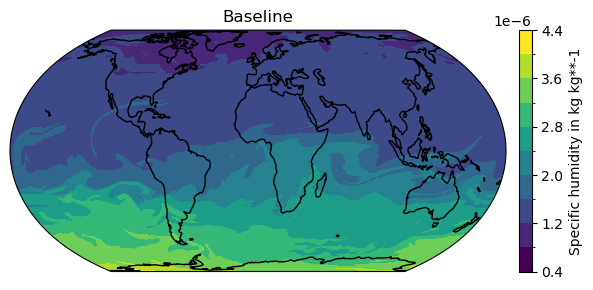

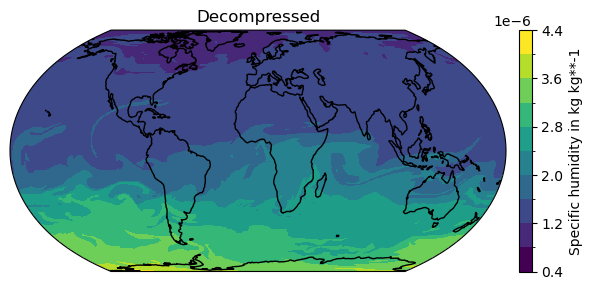

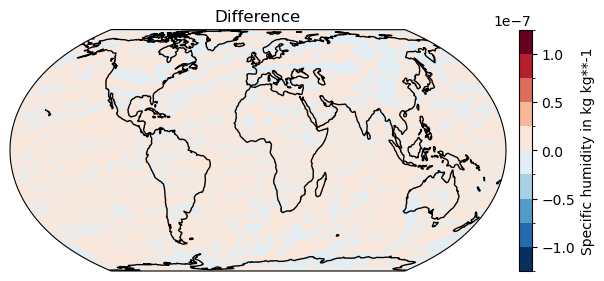

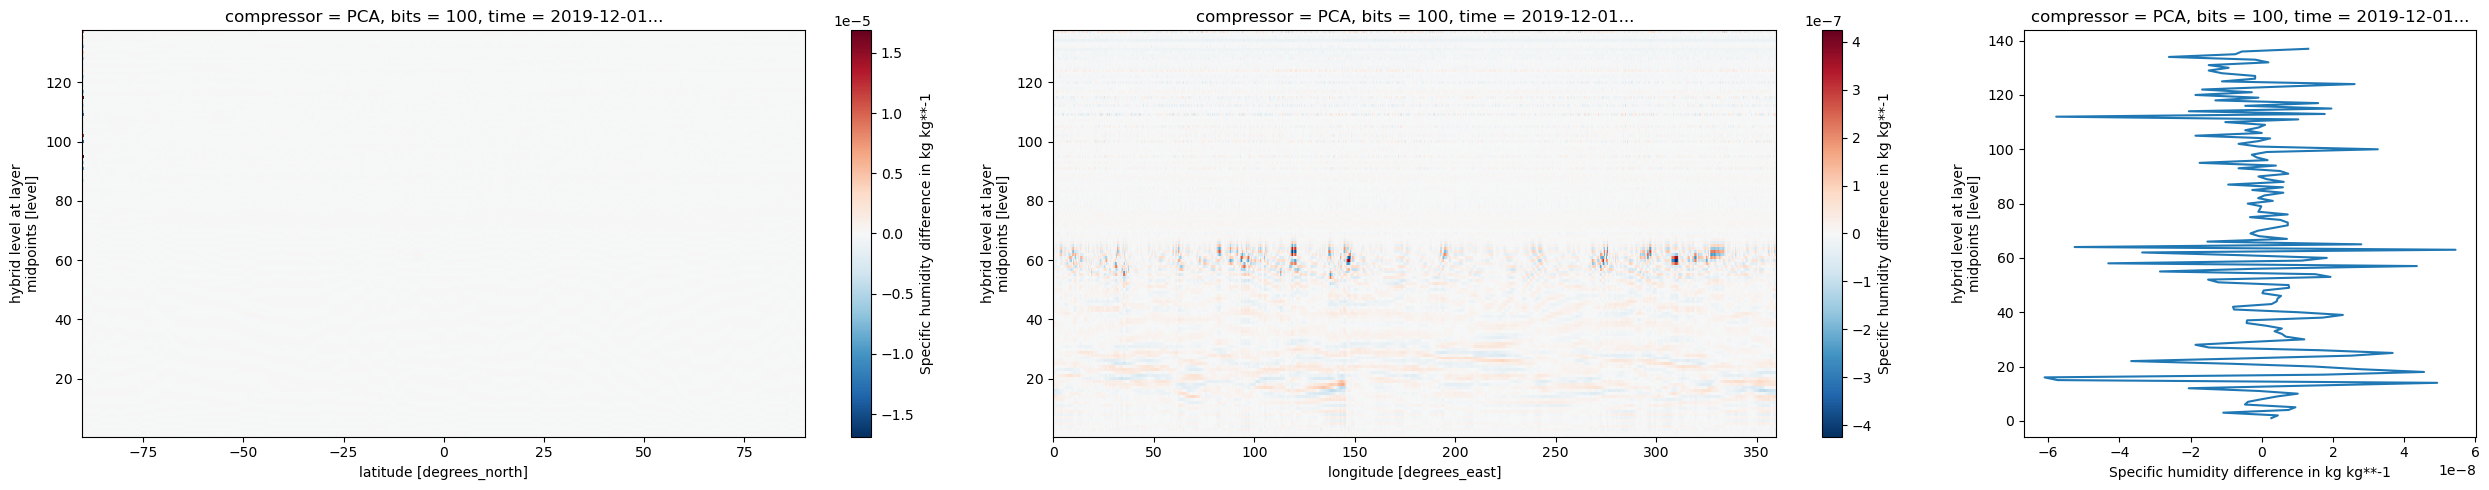

In [6]:
fcpy.spatialplot(
    ds=ds,
    baseline=fcpy.Identity(bits=32),
    var_name="q",
    compressor=fcpy.PCA(bits=100),
    metric=fcpy.Difference,
    latitude=0,
    longitude=0,
    lev=1,
    third_dim="lev",
)

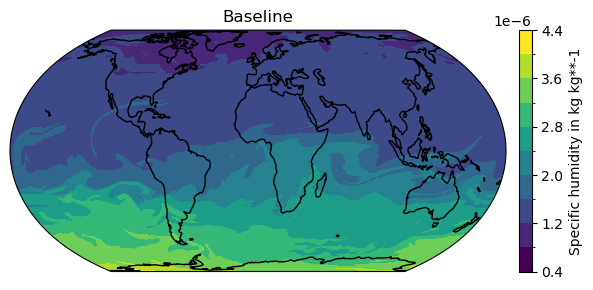

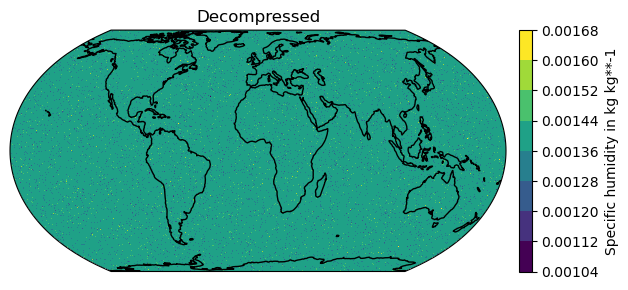

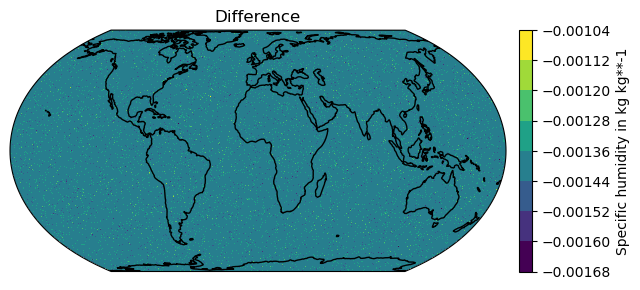

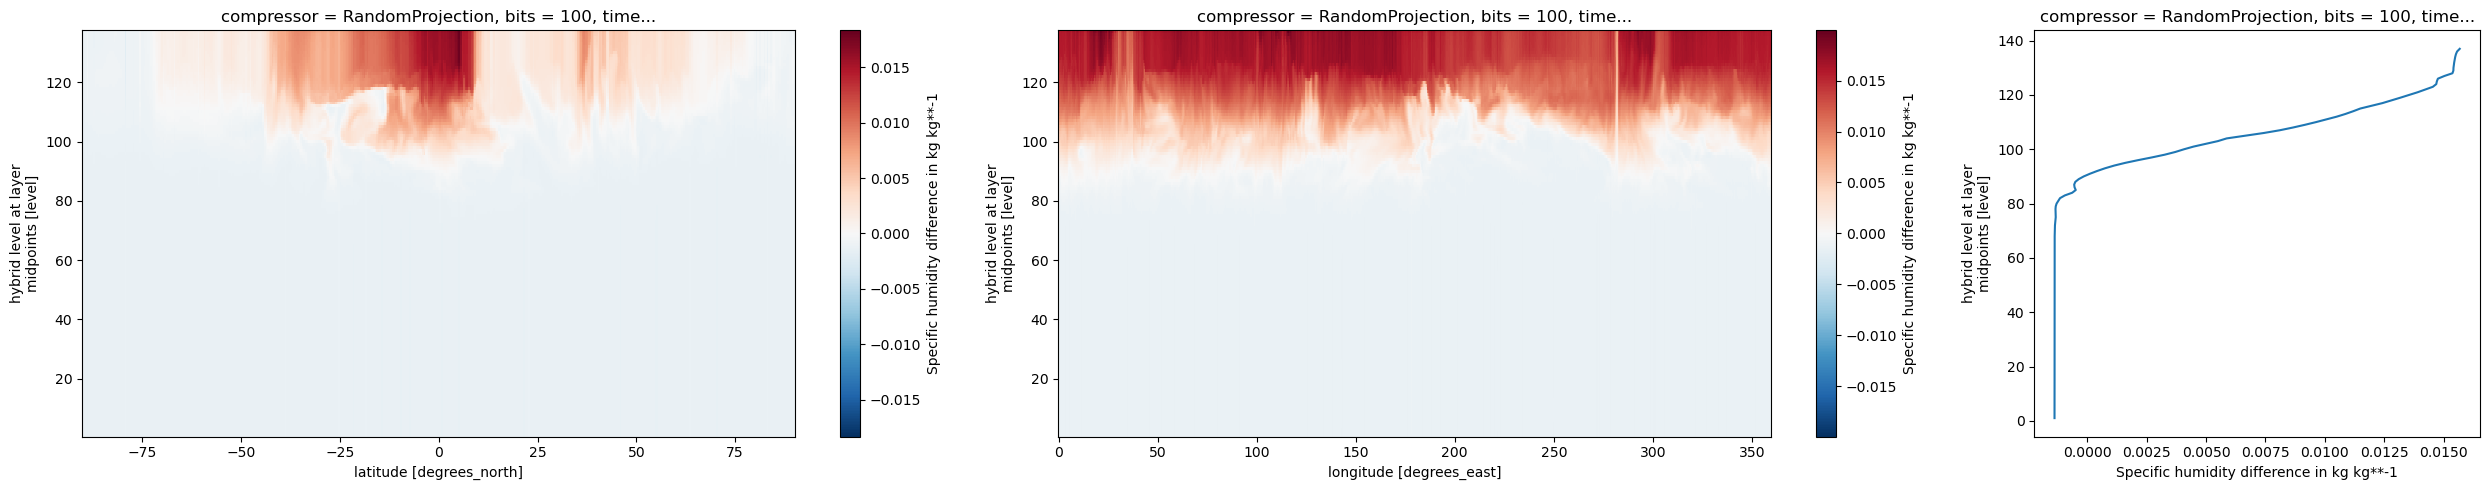

In [7]:
fcpy.spatialplot(
    ds=ds,
    baseline=fcpy.Identity(bits=32),
    var_name="q",
    compressor=fcpy.RandomProjection(bits=100),
    metric=fcpy.Difference,
    latitude=0,
    longitude=0,
    lev=1,
    third_dim="lev",
)

In [8]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.random_projection import SparseRandomProjection

In [9]:
arr = ds["q"].to_numpy()
time, lev, lat, lon = arr.shape

In [10]:
scaler = StandardScaler()

data = scaler.fit_transform(arr.reshape((time * lev * lat * lon, 1))).reshape(
    (time * lev, lat * lon)
)

In [11]:
data.shape

(137, 405900)

In [12]:
import xarray as xr

In [13]:
xr_data = xr.DataArray(
    data.reshape(time, lev, lat, lon),
    coords=ds["q"].coords, dims=ds["q"].dims,
    name=ds["q"].name, attrs=ds["q"].attrs,
)

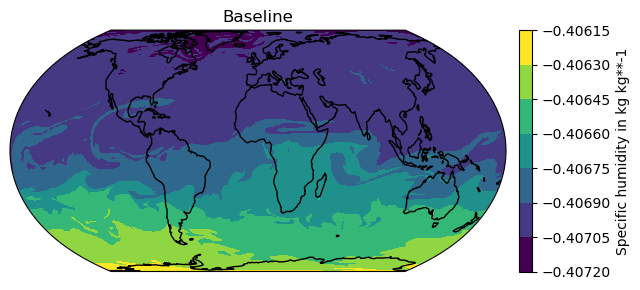

In [14]:
fcpy.suite.plot_spatial_single(
    xr_data.sel(dict(lev=1)),
    ds,
    "q",
    metric="Baseline",
)

In [15]:
%%time
transformer = SparseRandomProjection(
    random_state=42, n_components=250, #compute_inverse_components=True
)
compressed_data = transformer.fit_transform(data)

CPU times: user 512 ms, sys: 33.9 ms, total: 546 ms
Wall time: 544 ms


In [16]:
compressed_data.shape

(137, 250)

In [43]:
%%time
transformer.inverse_components_ = transformer._compute_inverse_components()
transformer.compute_inverse_components = True

CPU times: user 1min 43s, sys: 2min 36s, total: 4min 20s
Wall time: 1min 26s


In [59]:
%%time
sp.linalg.pinv(transformer.components_.toarray())

AttributeError: module 'scipy.sparse.linalg' has no attribute 'pinv'

In [51]:
%%time
decompressed_data = transformer.inverse_transform(compressed_data).reshape((time * lev * lat * lon, 1))

CPU times: user 1.04 s, sys: 11.6 s, total: 12.6 s
Wall time: 3.28 s


In [52]:
xr_decompressed_data = xr.DataArray(
    decompressed_data.reshape(time, lev, lat, lon),
    coords=ds["q"].coords, dims=ds["q"].dims,
    name=ds["q"].name, attrs=ds["q"].attrs,
)

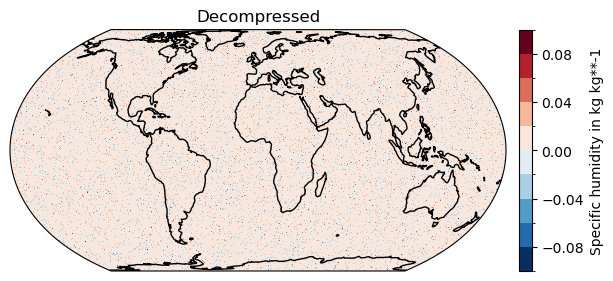

In [53]:
fcpy.suite.plot_spatial_single(
    xr_decompressed_data.sel(dict(lev=1)),
    ds,
    "q",
    metric="Decompressed",
)